In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=2000, n_features=15, n_classes=2)
X.shape, y.shape

((2000, 15), (2000,))

In [3]:
# X = np.hstack([np.ones((1000, 1)), X]) # to add intercept

In [4]:
X.mean(axis=0), X.std(axis=0) # no need to standardize

(array([ 0.03646189,  0.00449992,  0.02692477,  0.00117146, -0.01592412,
         0.01139726, -0.01702517, -0.00810121, -0.01031498,  0.01142867,
         0.03800961,  0.03424568,  0.01023096, -0.00696128, -0.01162984]),
 array([1.00653231, 1.18215268, 0.98158299, 0.98114361, 1.51054808,
        1.34927086, 0.98784812, 0.98384482, 0.98430931, 1.00879201,
        0.99632071, 0.9760215 , 0.99761023, 1.00548831, 1.39603494]))

## My Logistic Regression Class realization

### Features to add:
- <b>Different types of gradient descent (GD) </b>
    - Full GD (already implemented)
    - stochastic GD (SGD) one random object used to find gradient
    - stochastic average SAGD (several random objects used to find gradient)
    
- <b>Different loss functions </b>
    - Logloss (already implemented)
    - MSE :) for fun
- <b>Info about model </b>
    - Coefficients, intercept, parameters set (learning rate, regularization)
    - Stats (p-values, confidence intervals, model adequacy)
    - Quality metrics w
- <b> Marginal Effects (ME) </b>
        - ME for each factor (done)
        - ME at means, median, at any factors given (done)
        - average ME (AME) for each factor (done)
- <b> Non-linear factors </b>
        - ME for them also

In [5]:
class Logreg:
    def __init__(self, learning_rate=0.001, iterations=2000, C=2.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.C = C
        self.weights = None
        self.intercept = None
        
        # history
        self.iters_list = []
        self.loss_list = []
    
    def fit(self, X, y):
        # number of observations
        n = len(y)
        # number of features
        k = X.shape[1]
        
        # recreate history variables in case we fitted model before
        self.iters_list = []
        self.loss_list = []
        
        # 1. Initialize weights
        self.weights = np.zeros(k)
        self.intercept = 0
        
        for iteration in range(self.iterations):
            # 2 Predict
            z = np.dot(X, self.weights) + self.intercept
            y_hat = 1 / (1 + np.exp(-z))
            # 3 Calculate logloss
            #logloss = np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
            logloss = np.sum(np.log(1 + np.exp(- y * y_hat)))
        
            # 4 Derivative by weights
            derivative_weights = (1 / n) * np.dot(X.T, (y_hat - y)) # (a - y) * x
            derivative_intercept = (1 / n) * np.sum(y_hat - y)

            # 5 Update weights
            self.weights -= self.learning_rate * (derivative_weights + self.C * self.weights)
            self.intercept -= self.learning_rate * (derivative_intercept + self.C * self.intercept)
            
            #print('Iteration:', iteration, 'Total logLoss =', logloss)
            
            # history update
            self.iters_list.append(iteration)
            self.loss_list.append(logloss)
            # 6 Repeat
    

    def predict(self, X):
        z = np.dot(X, self.weights) + self.intercept
        pred = 1 / (1 + np.exp(-z))
        return np.array([1 if i > 0.5 else 0 for i in pred])
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def marginal_effects(self, X, option='all'):
        n, k = X.shape
        if option == 'all':
            z = np.dot(X, self.weights) + self.intercept
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(n, 1), logreg.weights.reshape(k, 1).T)
        elif option == 'at_means':
            z = np.dot(logreg.weights, np.mean(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        elif option == 'at_median':
            z = np.dot(logreg.weights, np.median(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        else:
            return 'Specify one of the following options: all, at_means or at_median'

### Instantiate, Fit and Predict

In [6]:
logreg = Logreg(C=1.0)

In [7]:
from sklearn.preprocessing import scale

In [8]:
X_scaled = scale(X)

In [9]:
logreg.fit(X, y)

In [10]:
mine_pred = logreg.predict(X)
np.unique(mine_pred)

array([0, 1])

#### Loss graph by iteration

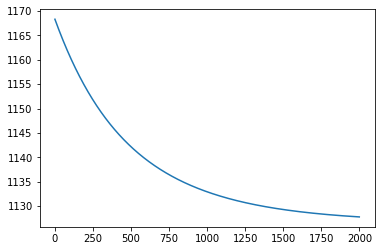

In [11]:
plt.plot(logreg.iters_list, logreg.loss_list)

#### Marginal effects for factors

In [12]:
marginal_effects = logreg.marginal_effects(X)

In [13]:
marginal_effects.shape

(2000, 15)

In [14]:
marginal_effects[:, 0] # for X1 factor

array([0.00139697, 0.00143555, 0.00143393, ..., 0.0015013 , 0.00142397,
       0.00127209])

In [15]:
marginal_effects[0, :] # for all factors for the first observation

array([ 1.39697402e-03, -5.21073441e-02,  1.44069848e-03,  1.83417876e-03,
        2.11252840e-02,  3.71046566e-03, -9.14015825e-05, -1.68960747e-04,
        3.61534676e-05,  1.85221014e-03,  9.84620728e-04,  3.70803989e-04,
        1.21126227e-03,  2.55493999e-03,  6.37768920e-02])

In [16]:
logreg.marginal_effects(X, option='at_means')

array([ 1.50272648e-03, -5.60519270e-02,  1.54976093e-03,  1.97302810e-03,
        2.27244911e-02,  3.99135196e-03, -9.83207821e-05, -1.81751260e-04,
        3.88903246e-05,  1.99242447e-03,  1.05915759e-03,  3.98874256e-04,
        1.30295615e-03,  2.74835173e-03,  6.86048724e-02])

In [17]:
logreg.marginal_effects(X, option='at_median')

array([ 1.50201942e-03, -5.60255537e-02,  1.54903175e-03,  1.97209976e-03,
        2.27137988e-02,  3.98947397e-03, -9.82745207e-05, -1.81665744e-04,
        3.88720261e-05,  1.99148700e-03,  1.05865924e-03,  3.98686580e-04,
        1.30234309e-03,  2.74705859e-03,  6.85725928e-02])

## Sklearn

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression(C=1.0)

In [20]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
lr.intercept_

array([0.02271892])

In [22]:
lr.coef_

array([[ 0.04099415, -1.01635612,  0.09459385,  0.04601976,  0.33993898,
         0.13230073, -0.04174805, -0.01658872,  0.00567071,  0.08416727,
         0.04386554, -0.02511855, -0.01016246,  0.14209428,  1.21266057]])

In [23]:
pred = lr.predict(X)

In [24]:
y.shape, pred.shape

((2000,), (2000,))

In [25]:
np.unique(y), np.unique(pred)

(array([0, 1]), array([0, 1]))

## Comparison: Mine VS Sklearn

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [27]:
accuracy_score(y, pred), roc_auc_score(y, pred)

(0.868, 0.8679916997924947)

In [28]:
accuracy_score(y, mine_pred), roc_auc_score(y, mine_pred)

(0.8665, 0.8664541613540339)

In [29]:
logreg.weights

array([ 6.01094018e-03, -2.24208987e-01,  6.19907908e-03,  7.89215740e-03,
        9.08984826e-02,  1.59654989e-02, -3.93285371e-04, -7.27009187e-04,
        1.55562185e-04,  7.96974332e-03,  4.23665453e-03,  1.59550612e-03,
        5.21185433e-03,  1.09934696e-02,  2.74421055e-01])

#### Predictions check for my logreg

In [30]:
mine_pred_proba = logreg.predict_proba(X)

In [31]:
mine_pred_proba[0], mine_pred[0]

(0.367354771982949, 0)

In [32]:
one_obs = X[0, :].T

In [33]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [34]:
1 / (1 + np.exp(-z)) # prediction is correct

0.367354771982949

In [35]:
one_obs

array([-0.34136928,  1.64169837,  0.85615357, -1.50317007,  1.53942119,
       -1.94937587, -1.27704878, -1.25619227,  0.02231574,  0.30748994,
        0.86388789,  1.06944406,  0.3000631 ,  0.29034106, -1.05194548])

In [36]:
one_obs[0] = one_obs[0] + 1

In [37]:
one_obs

array([ 0.65863072,  1.64169837,  0.85615357, -1.50317007,  1.53942119,
       -1.94937587, -1.27704878, -1.25619227,  0.02231574,  0.30748994,
        0.86388789,  1.06944406,  0.3000631 ,  0.29034106, -1.05194548])

In [38]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [39]:
1 / (1 + np.exp(-z))

0.36875285651348594

### Marginal Effects

In [40]:
# 1 / (1 + e^(-z)) where z = b0 + b1*x1 + ... + bn*xn
# so the ME for X1 will be e^(-z)/(1 + e^(-z))^2 * b1

#### Marginal effect for one observation

In [41]:
X[0, :].shape, logreg.weights.shape

((15,), (15,))

In [42]:
z = np.dot(X[0, :].T, logreg.weights) + logreg.intercept

In [43]:
logreg.weights[0] # the sign is negative, so the ME should also be negative

0.006010940178704021

In [44]:
np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0] # ME for X1 for one observation
# if X1 increases by 1 then probability of getting y=1 is decreased by this number

0.0013991917151668191

#### Another way of getting marginal effect using difference of probabilities

In [45]:
x = X[0, :].T

In [46]:
x

array([ 0.65863072,  1.64169837,  0.85615357, -1.50317007,  1.53942119,
       -1.94937587, -1.27704878, -1.25619227,  0.02231574,  0.30748994,
        0.86388789,  1.06944406,  0.3000631 ,  0.29034106, -1.05194548])

In [47]:
z_0 = np.dot(x, logreg.weights) + logreg.intercept

In [48]:
z_0

-0.5375708013081766

In [49]:
z_0 = 1 / (1 + np.exp(-z_0))

In [50]:
z_0

0.36875285651348594

In [51]:
x[0] = x[0] + 1

In [52]:
x

array([ 1.65863072,  1.64169837,  0.85615357, -1.50317007,  1.53942119,
       -1.94937587, -1.27704878, -1.25619227,  0.02231574,  0.30748994,
        0.86388789,  1.06944406,  0.3000631 ,  0.29034106, -1.05194548])

In [53]:
z_1 = np.dot(x, logreg.weights) + logreg.intercept

In [54]:
z_1

-0.5315598611294725

In [55]:
z_1 = 1 / (1 + np.exp(-z_1))

In [56]:
z_1

0.370153148729199

In [57]:
z_0, z_1

(0.36875285651348594, 0.370153148729199)

In [58]:
z_1 - z_0 # MARGINAL EFFECT FOR THE FIRST OBSERVATION. THE SAME AS IN THE BEGINING

0.0014002922157130837

#### Marginal effect for X1 and for all factors

In [59]:
X.shape, logreg.weights.shape

((2000, 15), (15,))

In [60]:
z = np.dot(X, logreg.weights) + logreg.intercept

In [61]:
ME_x1 = np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0]

In [62]:
z.shape, logreg.weights.shape

((2000,), (15,))

In [63]:
ME_all = np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(2000, 1), logreg.weights.reshape(15, 1).T)

In [64]:
ME_all.shape

(2000, 15)

In [65]:
ME_all[:6, 0] # ME for X1

array([0.00140139, 0.00143555, 0.00143393, 0.00146087, 0.00148819,
       0.00105326])

In [66]:
ME_x1[:6] # also ME for X1 but calculated separately

array([0.00140139, 0.00143555, 0.00143393, 0.00146087, 0.00148819,
       0.00105326])

In [67]:
np.mean(ME_x1) # AME average marginal effect for X1

0.0013551348072407135

In [68]:
logreg.marginal_effects(X)[:, 0].mean()

0.0013551348072407135

In [69]:
np.median(X, axis=0).reshape(1, 15)

array([[ 0.02931459,  0.15925469,  0.00247862,  0.03090391, -0.03866867,
         0.20624309, -0.0070681 ,  0.00171757, -0.01162739,  0.05508396,
         0.04246709,  0.03672219, -0.01073598,  0.00034449, -0.03198841]])

In [70]:
z = np.dot(logreg.weights, np.median(X, axis=0))

In [71]:
np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)

array([ 1.50201960e-03, -5.60255603e-02,  1.54903193e-03,  1.97209999e-03,
        2.27138015e-02,  3.98947444e-03, -9.82745323e-05, -1.81665765e-04,
        3.88720307e-05,  1.99148724e-03,  1.05865937e-03,  3.98686627e-04,
        1.30234325e-03,  2.74705892e-03,  6.85726008e-02])

In [72]:
logreg.marginal_effects(X, option='at_median')

array([ 1.50201960e-03, -5.60255603e-02,  1.54903193e-03,  1.97209999e-03,
        2.27138015e-02,  3.98947444e-03, -9.82745323e-05, -1.81665765e-04,
        3.88720307e-05,  1.99148724e-03,  1.05865937e-03,  3.98686627e-04,
        1.30234325e-03,  2.74705892e-03,  6.85726008e-02])